In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
import matplotlib.pyplot as plt
import json

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform_training = transforms.Compose([transforms.Resize((523,500)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                         transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=1),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])

transform = transforms.Compose([transforms.Resize((523,500)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

def tensor2image(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

### Must save dataset to G-Drive first!

In [4]:
!unzip drive/MyDrive/ML/102FlowersDataset/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: flower_data/flower_data/train/51/image_01359.jpg  
  inflating: flower_data/flower_data/train/51/image_01360.jpg  
  inflating: flower_data/flower_data/train/51/image_01361.jpg  
  inflating: flower_data/flower_data/train/51/image_01364.jpg  
  inflating: flower_data/flower_data/train/51/image_01365.jpg  
  inflating: flower_data/flower_data/train/51/image_01366.jpg  
  inflating: flower_data/flower_data/train/51/image_01367.jpg  
  inflating: flower_data/flower_data/train/51/image_01368.jpg  
  inflating: flower_data/flower_data/train/51/image_01369.jpg  
  inflating: flower_data/flower_data/train/51/image_01371.jpg  
  inflating: flower_data/flower_data/train/51/image_01372.jpg  
  inflating: flower_data/flower_data/train/51/image_01373.jpg  
  inflating: flower_data/flower_data/train/51/image_01374.jpg  
  inflating: flower_data/flower_data/train/51/image_01375.jpg  
  inflating: flower_data/flower_data/train/51/image_0

In [5]:
train_dataset = ImageFolder('flower_data/flower_data/train',transform=transform_training)
valid_dataset = ImageFolder('flower_data/flower_data/valid',transform=transform)
test_dataset  = ImageFolder('test set',transform=transform)
with open('cat_to_name.json') as f:
  cat_to_name = json.load(f)

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [6]:
print("Number of training images: ",len(train_dataset))
print("Number of validation images: ",len(valid_dataset))
print("Number of testing images: ",len(test_dataset))
print("Number of classes: ",len(train_dataset.classes))

Number of training images:  6552
Number of validation images:  818
Number of testing images:  206
Number of classes:  102


Text(0.5, 1.0, 'original image')

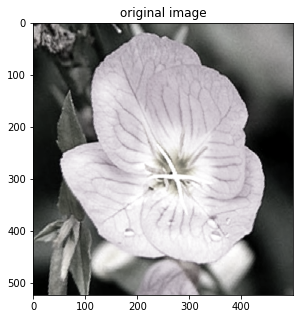

In [7]:
image, label  = train_dataset[0]
fig, ax1 = plt.subplots(figsize=(15,5),nrows=1,ncols=1)
ax1.imshow(tensor2image(image))
ax1.set_title("original image")

In [8]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

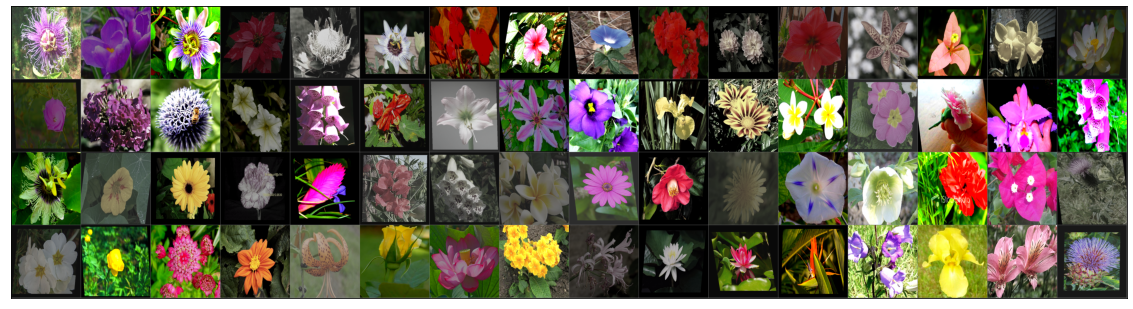

In [9]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(tensor2image(make_grid(images, nrow=16)))
    break

In [10]:
model =models.densenet121(pretrained=True).to(device)
#model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [11]:
for param in model.features.parameters():
  param.requires_grad = False

in_features = model.classifier.in_features
last_layer = nn.Linear(in_features, len(cat_to_name))
model.classifier = last_layer
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
epochs = 50

training_loss_history = []
training_corrects_history = []
validation_loss_history = []
validation_corrects_history = []

for epoch in range(epochs):
  
  training_loss = 0.0
  training_correct = 0.0
  validation_loss = 0.0
  validation_correct = 0.0
  
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = loss_func(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    training_loss += loss.item()
    training_correct += torch.sum(preds == labels.data)

  with torch.no_grad():
    for val_inputs, val_labels in valid_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = loss_func(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      validation_loss += val_loss.item()
      validation_correct += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = training_loss/len(train_loader.dataset)
    epoch_acc = training_correct.float()/ len(train_loader.dataset)

    training_loss_history.append(epoch_loss)
    training_corrects_history.append(epoch_acc)
    
    val_epoch_loss = validation_loss/len(valid_loader.dataset)
    val_epoch_acc = validation_correct.float()/ len(valid_loader.dataset)
    validation_loss_history.append(val_epoch_loss)
    validation_corrects_history.append(val_epoch_acc)

    print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc))

Epoch [0], train_loss: 0.0058, train_acc: 0.9534, val_loss: 0.0058, val_acc: 0.9401
Epoch [1], train_loss: 0.0060, train_acc: 0.9489, val_loss: 0.0058, val_acc: 0.9303
Epoch [2], train_loss: 0.0060, train_acc: 0.9473, val_loss: 0.0058, val_acc: 0.9364
Epoch [3], train_loss: 0.0059, train_acc: 0.9512, val_loss: 0.0058, val_acc: 0.9389
Epoch [4], train_loss: 0.0060, train_acc: 0.9501, val_loss: 0.0058, val_acc: 0.9328
Epoch [5], train_loss: 0.0060, train_acc: 0.9518, val_loss: 0.0058, val_acc: 0.9352
Epoch [6], train_loss: 0.0059, train_acc: 0.9518, val_loss: 0.0056, val_acc: 0.9377
Epoch [7], train_loss: 0.0059, train_acc: 0.9507, val_loss: 0.0057, val_acc: 0.9389
Epoch [8], train_loss: 0.0058, train_acc: 0.9510, val_loss: 0.0057, val_acc: 0.9413
Epoch [9], train_loss: 0.0060, train_acc: 0.9512, val_loss: 0.0056, val_acc: 0.9377
Epoch [10], train_loss: 0.0058, train_acc: 0.9548, val_loss: 0.0058, val_acc: 0.9352
Epoch [11], train_loss: 0.0058, train_acc: 0.9495, val_loss: 0.0057, val_ac

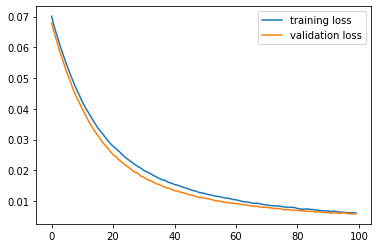

In [16]:
plt.plot(training_loss_history, label='training loss')
plt.plot(validation_loss_history, label='validation loss')
plt.legend()

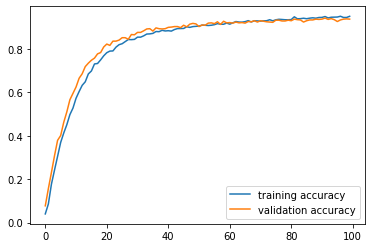

In [17]:
plt.plot(training_corrects_history, label='training accuracy')
plt.plot(validation_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
iterator = iter(valid_loader)
images, labels = iterator.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(30, 4))

for ndx in np.arange(20):
  img = fig.add_subplot(2, 10, ndx+1, xticks=[], yticks=[])
  plt.imshow(tensor2image(images[ndx]))
  img.set_title("{} ({})".format(cat_to_name[str(preds[ndx].item())], cat_to_name[str(labels[ndx].item())]), color=("green" if preds[ndx]==labels[ndx] else "red"))

In [27]:
torch.save(model.state_dict(), "plants_classification_cnn.pt")